**sklearn.neighbors**提供了 neighbors-based (基于邻居的) 无监督学习以及监督学习方法的功能。 无监督的最近邻是许多其它学习方法的基础，尤其是 manifold learning (流形学习) 和 spectral clustering (谱聚类)。 **neighbors-based (基于邻居的) 监督学习分为两种**： classification （分类）针对的是具有离散标签的数据，regression （回归）针对的是具有连续标签的数据。

最近邻方法背后的**原理**是从训练样本中找到与新点在距离上最近的预定数量的几个点，然后从这些点中预测标签。 这些点的数量可以是用户自定义的常量（K-最近邻学习）， 也可以根据不同的点的局部密度（基于半径的最近邻学习）确定。**距离通常可以通过任何度量来衡量**： standard Euclidean distance（标准欧式距离）是最常见的选择。Neighbors-based（基于邻居的）方法被称为 非泛化 机器学习方法， 因为它们只是简单地”记住”了其所有的训练数据（可能转换为一个快速索引结构，如 Ball Tree 或 KD Tree）。

尽管它简单，但最近邻算法已经成功地适用于很多的分类和回归问题，例如手写数字或卫星图像的场景。 作为一个 non-parametric（非参数化）方法，它经常成功地应用于决策边界非常不规则的分类情景下。

sklearn.neighbors 可以处理 Numpy 数组或 scipy.sparse 矩阵作为其输入。 对于密集矩阵，大多数可能的距离度量都是支持的。对于稀疏矩阵，支持搜索任意的 Minkowski 度量。

许多学习路径/方法都是依赖最近邻作为核心。 一个例子是 **核密度估计** , 在 密度估计 章节中有讨论。

# 无监督最近邻
NearestNeighbors （最近邻）实现了 unsupervised nearest neighbors learning（无监督的最近邻学习）。 它**为三种不同的最近邻算法提供统一的接口**：BallTree, KDTree, 还有基于 sklearn.metrics.pairwise 的 brute-force 算法。算法的选择可通过关键字 'algorithm' 来控制， 并必须是 ['auto', 'ball_tree', 'kd_tree', 'brute'] 其中的一个。当设置为默认值 'auto' 时，算法会尝试从训练数据中确定最佳方法。有关上述每个选项的优缺点，参见 Nearest Neighbor Algorithms_ 。

警告

关于最近邻算法，如果邻居k+1 和邻居 k 具有相同的距离，但具有不同的标签， 结果将取决于训练数据的顺序。

## 找到最近邻
为了完成找到两组数据集中最近邻点的简单任务, 可以使用 sklearn.neighbors 中的无监督算法:

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices  

array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 0],
       [3, 4, 5],
       [4, 3, 5],
       [5, 4, 3]], dtype=int64)

In [9]:
distances

array([[0.        , 1.        , 2.23606798],
       [0.        , 1.        , 1.41421356],
       [0.        , 1.41421356, 2.23606798],
       [0.        , 1.        , 2.23606798],
       [0.        , 1.        , 1.41421356],
       [0.        , 1.41421356, 2.23606798]])

还可以有效地生成一个稀疏图来标识相连点之间的连接情况

In [10]:
nbrs.kneighbors_graph(X).toarray()

array([[1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.]])

我们的数据集是结构化的，因此按索引顺序的相邻点就在参数空间相邻，从而生成了近似 K-nearest neighbors（K-近邻）的块对角矩阵。 这种稀疏图在各种的利用点之间的空间关系进行无监督学习的情况下都很有用

## KDTree 和 BallTree 类

另外，我们可以使用 KDTree 或 BallTree 来找最近邻。 这是上文使用过的 NearestNeighbors 类所包含的功能。 KDTree 和 BallTree 具有相同的接口； 我们将在这里展示使用 KDTree 的例子：

In [11]:
from sklearn.neighbors import KDTree
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
distance,indices=kdt.query(X, k=2)#, return_distance=False)   
indices,distance


(array([[0, 1],
        [1, 0],
        [2, 1],
        [3, 4],
        [4, 3],
        [5, 4]], dtype=int64),
 array([[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.41421356],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.41421356]]))

# 最近邻分类
最近邻分类属于 基于实例的学习 或 非泛化学习 ：它不会去构造一个泛化的内部模型，而是简单地存储训练数据的实例。 分类是由每个点的最近邻的简单多数投票中计算得到的：一个查询点的数据类型是由它最近邻点中最具代表性的数据类型来决定的。

scikit-learn 实现了两种不同的最近邻分类器： 基于每个查询点的k个最近邻实现，其中k是用户指定的整数值。RadiusNeighborsClassifier 基于每个查询点的固定半径$r$内的邻居数量实现， 其中$r$是用户指定的浮点数值。

$k$ -邻居分类是KNeighborsClassifie的技术中比较常用的一种。 值的最佳选择是高度依赖数据的：通常较大的$k$  是会抑制噪声的影响，但是使得分类界限不明显。

如果数据是不均匀采样的，那么 RadiusNeighborsClassifier 中的基于半径的近邻分类可能是更好的选择。用户指定一个固定半径 ，使得稀疏邻居中的点使用较少的最近邻来分类。对于高维参数空间，这个方法会由于所谓的 “维度灾难” 而变得不那么有效。

基本的最近邻分类使用统一的权重：分配给查询点的值是从最近邻的简单多数投票中计算出来的。 在某些环境下，最好对邻居进行加权，使得更近邻更有利于拟合。可以通过 weights 关键字来实现。默认值 weights = 'uniform' 为每个近邻分配**统一的权重**。而 weights = 'distance' 分配**权重与查询点的距离成反比*。 或者，用户可以自定义一个距离函数用来计算权重。

示例:

Nearest Neighbors Classification: 使用最近邻进行分类的示例

Automatically created module for IPython interactive environment


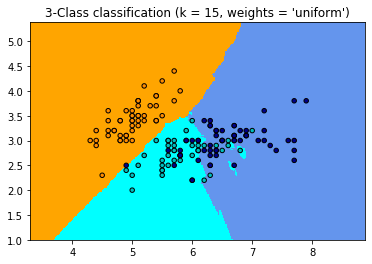

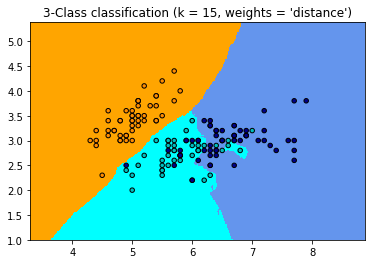

In [15]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])#是按行连接两个矩阵,就是把两矩阵左右相加,要求行数相等。

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

# 最近邻回归
最近邻回归是用在数据标签为连续变量，而不是离散变量的情况下。分配给查询点的标签是由它的最近邻标签的均值计算而来的。

**scikit-learn 实现了两种不同的最近邻回归**：KNeighborsRegressor 基于每个查询点的$k$  个最近邻实现， 其中$k$是用户指定的整数值。RadiusNeighborsRegressor 基于每个查询点的固定半径$r$内的邻点数量实现， 其中$r$是用户指定的浮点数值。

基本的最近邻回归使用统一的权重：即，本地邻域内的每个邻点对查询点的分类贡献一致。 在某些环境下，对邻点加权可能是有利的，使得附近点对于回归所作出的贡献多于远处点。 这可以通过 weights 关键字来实现。默认值 weights = 'uniform' 为所有点分配同等权重。 而 weights = 'distance' 分配的权重与查询点距离呈反比。 或者，用户可以自定义一个距离函数用来计算权重。

示例：使用最近邻进行回归的示例。

Automatically created module for IPython interactive environment


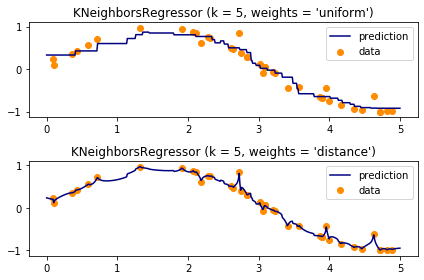

In [16]:
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Fabian Pedregosa <fabian.pedregosa@inria.fr>
#
# License: BSD 3 clause (C) INRIA


# #############################################################################
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, color='darkorange', label='data')
    plt.plot(T, y_, color='navy', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.tight_layout()
plt.show()

使用最近邻进行多输出回归的示例。

（略）

# 最近邻算法

## 暴力计算

最近邻的快速计算是机器学习中一个活跃的研究领域。最简单的近邻搜索的实现涉及数据集中所有成对点之间距离的暴力计算： 对于 D 维度中的 N 个样本来说, 这个方法的复杂度是 $O[D N^2]$。 对于小数据样本，高效的暴力近邻搜索是非常有竞争力的。 然而，随着样本数 N 的增长，暴力方法很快变得不切实际了。在 sklearn.neighbors 类中， 暴力近邻搜索通过关键字 algorithm = 'brute' 来指定，并通过 sklearn.metrics.pairwise 中的例程来进行计算。

## K-D 树

为了解决效率低下的暴力计算方法，已经发明了大量的基于树的数据结构。总的来说， 这些结构**试图通过有效地编码样本**的 aggregate distance (聚合距离) 信息来减少所需的距离计算量。 基本思想是，若 A 点距离 B 点非常远，B 点距离 C 点非常近， 可知 A 点与 C 点很遥远，不需要明确计算它们的距离。 通过这样的方式，近邻搜索的计算成本可以降低为 $O[D N \log(N)]$ 或更低。 这是对于暴力搜索在大样本数 N 中表现的显著改善。

利用这种聚合信息的早期方法是 KD tree 数据结构（ K-dimensional tree 的简写）, 它将二维 Quad-trees 和三维 Oct-trees 推广到任意数量的维度. KD 树是一个二叉树结构，它沿着数据轴递归地划分参数空间，将其划分为嵌入数据点的嵌套的各向异性区域。 KD 树的构造非常快：因为只需沿数据轴执行分区, 无需计算 D-dimensional 距离。 一旦构建完成, 查询点的最近邻距离计算复杂度仅为 $O[\log(N)]$ 。 虽然 KD 树的方法对于低维度 (D < 20) 近邻搜索非常快, 当 D 增长到很大时, 效率变低: 这就是所谓的 $“维度灾难”$ 的一种体现。 在 scikit-learn 中, KD 树近邻搜索可以使用关键字 algorithm = 'kd_tree' 来指定, 并且使用类 KDTree 来计算。

## Ball 树

为了解决 KD 树在高维上效率低下的问题, ball 树 数据结构就被研发出来了. 其中 KD 树沿笛卡尔轴（即坐标轴）分割数据, ball 树在沿着一系列的 hyper-spheres 来分割数据. 通过这种方法构建的树要比 KD 树消耗更多的时间, 但是这种数据结构对于高结构化的数据是非常有效的, 即使在高维度上也是一样.

ball 树将数据递归地划分为由质心 C 和半径 R 定义的节点,使得节点中的每个点位于由 r 和 C 定义的 hyper-sphere 内. 通过使用 triangle inequality（三角不等式） 减少近邻搜索的候选点数:

$$|x+y| \leq |x| + |y|$$

通过这种设置, 测试点和质心之间的单一距离计算足以确定距节点内所有点的距离的下限和上限. 由于 ball 树节点的球形几何, 它在高维度上的性能超出 KD-tree, 尽管实际的性能高度依赖于训练数据的结构. 在 scikit-learn 中, 基于 ball 树的近邻搜索可以使用关键字 algorithm = 'ball_tree' 来指定, 并且使用类 sklearn.neighbors.BallTree 来计算. 或者, 用户可以直接使用 BallTree 类.


## 最近邻算法的选择

对于给定数据集的最优算法是一个复杂的选择, 并且取决于多个因素:

    •样本数量 N (i.e. n_samples) 和维度 D (例如. nfeatures).

        ◦Brute force 查询时间以 O[D N] 增长
        ◦Ball tree 查询时间大约以 O[D \log(N)] 增长
        ◦KD tree 的查询时间 的变化是很难精确描述的.对于较小的 D (小于20) 的成本大约是 O[D\log(N)], 并且 KD 树更加有效.对于较大的 D 成本的增加接近 O[DN], 由于树结构引起的开销会导致查询效率比暴力还要低.

        对于小数据集 (n小于30), log(N)相当于N, 暴力算法比基于树的算法更加有效. KDTree 和 BallTree 通过提供一个 leaf size 参数来解决这个问题: 这控制了查询切换到暴力计算样本数量. 使得两种算法对较小的 N的效率都能接近于暴力计算.

    •数据结构: 数据的 intrinsic dimensionality (本征维数) 和/或数据的 sparsity (稀疏度). 本征维数是指数据所在的流形的维数 d \le D, 在参数空间可以是线性或非线性的. 稀疏度指的是数据填充参数空间的程度(这与“稀疏”矩阵中使用的概念不同, 数据矩阵可能没有零项, 但是从这个意义上来讲,它的 structure 仍然是 “稀疏” 的)。
        ◦Brute force (暴力查询)时间不受数据结构的影响。
        ◦Ball tree 和 KD tree 的数据结构对查询时间影响很大. 一般地, 小维度的 sparser (稀疏) 数据会使查询更快. 因为 KD 树的内部表现形式是与参数轴对齐的, 对于任意的结构化数据它通常不会表现的像 ball tree 那样好.

        在机器学习中往往使用的数据集是非常结构化的, 而且非常适合基于树结构的查询。

    •query point（查询点）所需的近邻数 k 。

> * Brute force 查询时间几乎不受 k 值的影响. > * Ball tree 和 KD tree 的查询时间会随着 k 的增加而变慢. 这是由于两个影响: 首先, k 的值越大在参数空间中搜索的部分就越大. 其次, 使用 k > 1 进行树的遍历时, 需要对内部结果进行排序.

当 k 相比 N 变大时, 在基于树的查询中修剪树枝的能力是减弱的. 在这种情况下, 暴力查询会更加有效.


    •query points（查询点）数. ball tree 和 KD Tree 都需要一个构建阶段. 在许多查询中分摊时，这种结构的成本可以忽略不计。 如果只执行少量的查询, 可是构建成本却占总成本的很大一部分. 如果仅需查询很少的点, 暴力方法会比基于树的方法更好.


一般地, 如果 k >= N/2， 或输入是稀疏矩阵，或'effective_metric_' 不在 'kd_tree' 或 'ball_tree' 的 'VALID_METRICS' 列表中，那么algorithm = 'auto'选择 'brute'。 如果 k < N/2 并且 'effective_metric_' 在 'kd_tree' 的 'VALID_METRICS' 列表中，那么 algorithm = 'auto'选择 'kd_tree'。 如果 k < N/2 并且 'effective_metric_' 在 'ball_tree' 的 'VALID_METRICS' 列表中，那么 algorithm = 'auto'选择 'ball_tree'。 这种选择基于以下假设: 查询点的数量与训练点的数量至少在相同的数量级, 并且 leaf_size 接近其默认值 30.


 ## leaf_size 的影响

如上所述, 对于小样本暴力搜索是比基于树的搜索更有效的方法. 这一事实在 ball 树和 KD 树中被解释为在叶节点内部切换到暴力搜索. 该开关的级别可以使用参数 leaf_size 来指定. 这个参数选择有很多的效果:

    构造时间: 更大的 leaf_size 会导致更快的树构建时间, 因为需要创建更少的节点.

    查询时间:一个大或小的 leaf_size 可能会导致次优查询成本. 当 leaf_size 接近 1 时, 遍历节点所涉及的开销大大减慢了查询时间. 当 leaf_size, 接近训练集的大小，查询变得本质上是暴力的. 这些之间的一个很好的妥协是 leaf_size = 30, 这是该参数的默认值.

    内存:随着leaf_size的增加，存储树结构所需的内存减少。 对于存储每个节点的D维质心的ball tree，这点至关重要。 针对 BallTree 所需的存储空间近似于 1 / leaf_size 乘以训练集的大小.

    leaf_size 不被 brute force queries（暴力查询）所引用.


# 最近质心分类

该 NearestCentroid 分类器是一个简单的算法, 通过其成员的质心来表示每个类。 实际上, 这使得它类似于 sklearn.KMeans 算法的标签更新阶段. 它也没有参数选择, 使其成为良好的基准分类器. 然而，它确实受到非凸类的影响，即当类有显著不同的方差时。所以这个分类器假设所有维度的方差都是相等的。 对于没有做出这个假设的更复杂的方法, 请参阅线性判别分析 (sklearn.discriminant_analysis.LinearDiscriminantAnalysis) 和二次判别分析 (sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis). 默认的 NearestCentroid 用法示例如下:



In [18]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = NearestCentroid()
clf.fit(X, y)
NearestCentroid(metric='euclidean', shrink_threshold=None)
print(clf.predict([[-0.8, -1]]))

[1]


f:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


 ## 最近缩小质心

该 NearestCentroid 分类器有一个 shrink_threshold 参数, 它实现了 nearest shrunken centroid 分类器. 实际上, 每个质心的每个特征的值除以该特征的类中的方差. 然后通过 shrink_threshold 来减小特征值. 最值得注意的是, 如果特定特征值过0, 则将其设置为0. 实际上，这个方法移除了影响分类器的特征。 这很有用, 例如, 去除噪声特征.

在以下例子中, 使用一个较小的 shrink 阀值将模型的准确度从 0.81 提高到 0.82.


Automatically created module for IPython interactive environment
None 0.8133333333333334
0.2 0.82


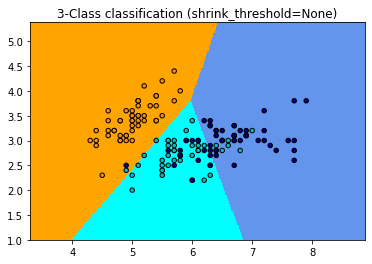

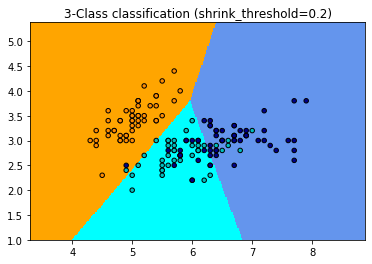

In [19]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.neighbors import NearestCentroid

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()
# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for shrinkage in [None, .2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = NearestCentroid(shrink_threshold=shrinkage)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(shrinkage, np.mean(y == y_pred))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.title("3-Class classification (shrink_threshold=%r)"
              % shrinkage)
    plt.axis('tight')

plt.show()


# 邻域成分分析

邻域成分分析(NCA, NeighborhoodComponentsAnalysis)是一种距离度量学习算法，其目的是提高最近邻分类相对于标准欧氏距离的准确性。该算法直接最大化训练集上k近邻(KNN)得分的随机变量，还可以拟合数据的低维线性投影，用于数据可视化和快速分类。
